# Double Pendulum with Python package PyDy

In [12]:
from __future__ import print_function, division
from sympy import symbols, simplify
from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame, Point
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex='mathjax', pretty_print=False)
from sympy.physics.mechanics import inertia, RigidBody
from sympy import trigsimp
from sympy.physics.mechanics import KanesMethod
from numpy import deg2rad, rad2deg, array, zeros, linspace
from scipy.integrate import odeint
from pydy.codegen.ode_function_generators import generate_ode_function
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ivisual import *
from IPython.display import display, clear_output

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Reference frames

In [1]:
inertial_frame = ReferenceFrame('I')

pendulum_frames = [ReferenceFrame('P0'),
                   ReferenceFrame('P1')]


(MainThread) backend module://ipykernel.pylab.backend_inline version unknown


ERROR! Session/line number was not unique in database. History logging moved to new session 435


In [2]:
psis = [dynamicsymbols('psi0'), #Pendulum1 angle
        dynamicsymbols('psi1')] #Pendulum2 angle


In [3]:
pendulum_frames[0].orient(inertial_frame, 'Axis', (psis[0], inertial_frame.z))
pendulum_frames[1].orient(pendulum_frames[0], 'Axis', (psis[1], pendulum_frames[0].z))


In [4]:
pendulum_frames[0].dcm(inertial_frame)

Matrix([
[ cos(psi0), sin(psi0), 0],
[-sin(psi0), cos(psi0), 0],
[         0,         0, 1]])

In [5]:
simplify(pendulum_frames[1].dcm(inertial_frame))

Matrix([
[ cos(psi0 + psi1), sin(psi0 + psi1), 0],
[-sin(psi0 + psi1), cos(psi0 + psi1), 0],
[                0,                0, 1]])

## Define some points

In [6]:
attachment = Point('A')

Lcgs = [symbols('Lcg0'),
       symbols('Lcg1')]

#end_points = [symbols('end0'),
#              symbols('end1')]

pendulum_lengths = [symbols('L0'),
                    symbols('L1')]
    

pendulum_mass_centers = [Point('cg0'),
                        Point('cg1')]

pendulum_end_points = [Point('end0'),
                       Point('end1')]

pendulum_end_points[0].set_pos(attachment, pendulum_lengths[0]*pendulum_frames[0].y)
pendulum_end_points[1].set_pos(pendulum_end_points[0], pendulum_lengths[1]*pendulum_frames[1].y)

pendulum_mass_centers[0].set_pos(attachment, Lcgs[0]*pendulum_frames[0].y)
pendulum_mass_centers[1].set_pos(pendulum_end_points[0], Lcgs[1]*pendulum_frames[1].y)


## Kinematical Differential Equations

In [7]:
rs = [dynamicsymbols('r0'), # Pendulum0 rate
      dynamicsymbols('r1')] # Pendulum1 rate



In [8]:
kinematical_differential_equations = [rs[0] - psis[0].diff(),
                                      rs[1] - psis[1].diff()]
kinematical_differential_equations

[r0 - psi0', r1 - psi1']

## Angular Velocities

In [9]:
pendulum_frames[0].set_ang_vel(inertial_frame,rs[0]*inertial_frame.z)
pendulum_frames[1].set_ang_vel(pendulum_frames[0],rs[1]*inertial_frame.z)


In [10]:
pendulum_frames[0].ang_vel_in(inertial_frame)

r0*I.z

In [11]:
pendulum_frames[1].ang_vel_in(inertial_frame)

(r0 + r1)*I.z

## Linear Velocities

In [13]:
attachment.set_vel(inertial_frame, 0)


In [14]:
pendulum_mass_centers[0].v2pt_theory(attachment, inertial_frame, pendulum_frames[0])
pendulum_mass_centers[0].vel(inertial_frame)

- Lcg0*r0*P0.x

In [15]:
pendulum_end_points[0].v2pt_theory(attachment, inertial_frame, pendulum_frames[0])
pendulum_end_points[0].vel(inertial_frame)

- L0*r0*P0.x

In [16]:
pendulum_mass_centers[1].v2pt_theory(pendulum_end_points[0], inertial_frame, pendulum_frames[1])
pendulum_mass_centers[1].vel(inertial_frame)

- L0*r0*P0.x - Lcg1*(r0 + r1)*P1.x

## Mass

In [17]:
pendulum_masses = [symbols('m_P0'),symbols('m_P1')]

## Inertia

In [101]:
Izzs = [symbols('I_zz0'),symbols('I_zz1')]

In [102]:
pendulum_dyadics = [inertia(pendulum_frames[0], 0, 0, Izzs[0]),
                   inertia(pendulum_frames[1], 0, 0, Izzs[1])]

In [103]:
pendulum_dyadics[0]

I_zz0*(P0.z|P0.z)

In [104]:
pendulum_dyadics[0].to_matrix(pendulum_frames[0])

Matrix([
[0, 0,     0],
[0, 0,     0],
[0, 0, I_zz0]])

In [105]:
pendulum_central_inertias = [(pendulum_dyadics[0], pendulum_mass_centers[0]),
                             (pendulum_dyadics[1], pendulum_mass_centers[1])]
                             

In [106]:
pendulums = [RigidBody('Pendulum0', pendulum_mass_centers[0], pendulum_frames[0],pendulum_masses[0], 
                       pendulum_central_inertias[0]),
             RigidBody('Pendulum1', pendulum_mass_centers[1], pendulum_frames[1],pendulum_masses[1], 
                       pendulum_central_inertias[1])]

## Equations of Motion

In [107]:
coordinates = psis
coordinates

[psi0, psi1]

In [108]:
speeds = rs
speeds

[r0, r1]

In [109]:
kane = KanesMethod(inertial_frame, coordinates, speeds, kinematical_differential_equations)

In [110]:
g = symbols('g')

In [111]:
pendulum_grav_force_vectors = [pendulum_masses[0] * g * inertial_frame.y,
                               pendulum_masses[1] * g * inertial_frame.y]
pendulum_grav_force_vectors

[g*m_P0*I.y, g*m_P1*I.y]

In [112]:
pendulum_grav_forces = [(pendulum_mass_centers[0], pendulum_grav_force_vectors[0]),
                        (pendulum_mass_centers[1], pendulum_grav_force_vectors[1])]

In [113]:
attachement_torques = [dynamicsymbols('T_a0'),
                       dynamicsymbols('T_a1')]

pendulum_torque_vectors = [attachement_torques[0] * inertial_frame.z,
                           attachement_torques[1] * inertial_frame.z]
                           
pendulum_torque_vectors

[T_a0*I.z, T_a1*I.z]

In [114]:
pendulum_torques = [(pendulum_frames[0], pendulum_torque_vectors[0]),
                    (pendulum_frames[1], pendulum_torque_vectors[1])]

In [115]:
#loads = [pendulum_grav_force,
#        pendulum_torque]
loads = pendulum_grav_forces

loads

[(cg0, g*m_P0*I.y), (cg1, g*m_P1*I.y)]

In [116]:
bodies = pendulums

In [117]:
fr, frstar = kane.kanes_equations(bodies = bodies,loads = loads)

In [118]:
trigsimp(fr + frstar)

Matrix([
[L0*Lcg1*m_P1*(r0 + r1)**2*sin(psi1) - L0*Lcg1*m_P1*r0**2*sin(psi1) - L0*g*m_P1*sin(psi0) - Lcg0*g*m_P0*sin(psi0) - Lcg1*g*m_P1*sin(psi0 + psi1) - (I_zz1 + Lcg1*m_P1*(L0*cos(psi1) + Lcg1))*r1' - (I_zz0 + I_zz1 + Lcg0**2*m_P0 + m_P1*(L0**2 + 2*L0*Lcg1*cos(psi1) + Lcg1**2))*r0'],
[                                                                                                                                          -L0*Lcg1*m_P1*r0**2*sin(psi1) - Lcg1*g*m_P1*sin(psi0 + psi1) - (I_zz1 + Lcg1**2*m_P1)*r1' - (I_zz1 + Lcg1*m_P1*(L0*cos(psi1) + Lcg1))*r0']])

In [119]:
mass_matrix = trigsimp(kane.mass_matrix_full)
mass_matrix

Matrix([
[1, 0,                                                                           0,                                       0],
[0, 1,                                                                           0,                                       0],
[0, 0, I_zz0 + I_zz1 + Lcg0**2*m_P0 + m_P1*(L0**2 + 2*L0*Lcg1*cos(psi1) + Lcg1**2), I_zz1 + Lcg1*m_P1*(L0*cos(psi1) + Lcg1)],
[0, 0,                                     I_zz1 + Lcg1*m_P1*(L0*cos(psi1) + Lcg1),                    I_zz1 + Lcg1**2*m_P1]])

In [120]:
forcing_vector = trigsimp(kane.forcing_full)
forcing_vector

Matrix([
[                                                                                                                                        r0],
[                                                                                                                                        r1],
[2*L0*Lcg1*m_P1*r0*r1*sin(psi1) + L0*Lcg1*m_P1*r1**2*sin(psi1) - L0*g*m_P1*sin(psi0) - Lcg0*g*m_P0*sin(psi0) - Lcg1*g*m_P1*sin(psi0 + psi1)],
[                                                                                      -Lcg1*m_P1*(L0*r0**2*sin(psi1) + g*sin(psi0 + psi1))]])

## Simulation

In [138]:
constants = [Lcgs[0],
             pendulum_lengths[0],
             pendulum_masses[0],            
             Izzs[0],
             Lcgs[1],
             pendulum_masses[1],            
             Izzs[1],
             g]

In [139]:
constants

[Lcg0, L0, m_P0, I_zz0, Lcg1, m_P1, I_zz1, g]

In [140]:
coordinates = psis
coordinates

[psi0, psi1]

In [141]:
speeds = rs
speeds

[r0, r1]

In [142]:
#specified = [pendulum_torque]
specified = []


right_hand_side = generate_ode_function(forcing_vector, coordinates,
                                        speeds, constants,
                                        mass_matrix=mass_matrix,
                                        specifieds=specified)

In [143]:
help(right_hand_side)

Help on function rhs in module pydy.codegen.ode_function_generators:

rhs(*args)
    Returns the derivatives of the states, i.e. numerically evaluates the right
    hand side of the first order differential equation.
    
    x' = f(x, t, r, p)
    
    Parameters
    x : ndarray, shape(4,)
        The state vector is ordered as such:
            - psi0(t)
            - psi1(t)
            - r0(t)
            - r1(t)
    t : float
        The current time.
    r : dictionary; ndarray, shape(0,); function
    
        There are three options for this argument. (1) is more flexible but
        (2) and (3) are much more efficient.
    
        (1) A dictionary that maps the specified functions of time to floats,
        ndarrays, or functions that produce ndarrays. The keys can be a single
        specified symbolic function of time or a tuple of symbols. The total
        number of symbols must be equal to 0. If the value is a
        function it must be of the form g(x, t), where x is t

## Set the Initial Conditions, Parameter Values, and Time Array

In [126]:
x0 = array([deg2rad(10),deg2rad(10),0,0])
x0

array([0.17453293, 0.17453293, 0.        , 0.        ])

In [144]:
numerical_constants =  np.array([5,  # pendulum_length [m]
                                 10,
                         10,  # pendulum_mass [kg]
                        10,  # pendulum_inertia [kg*m^2]
                        5,  # pendulum_length [m]
                        10,  # pendulum_mass [kg]
                        10,  # pendulum_inertia [kg*m^2]    
                        9.81])  # acceleration due to gravity [m/s^2]


In [145]:
# %load exercise_solutions/n07_simulation_sim-setup.py
#numerical_specified = zeros(3)
#numerical_specified = {}
numerical_specified = {}
#numerical_specified['L0'] = 10
#numerical_specified['L'] = 10



args = {'constants': numerical_constants,
        'specified': numerical_specified}

frames_per_sec = 60
final_time = 5.0

t = linspace(0.0, final_time, final_time * frames_per_sec)

/Users/martinalexandersson/Dev/ForceMan/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


In [146]:
right_hand_side(x0, 0.0, numerical_specified, numerical_constants)

array([ 0.        ,  0.        ,  0.1899266 , -1.19485536])

## Integrate the Equations of Motion

In [147]:
y = odeint(right_hand_side, x0, t, args=(numerical_specified, numerical_constants))

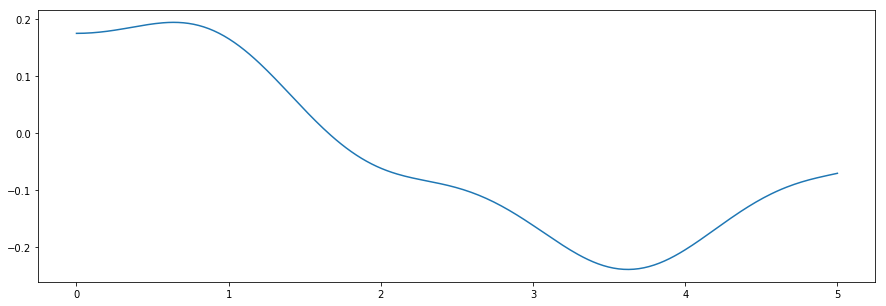

In [148]:
fig,ax = plt.subplots()
fig.set_size_inches(15,5)

ax.plot(t,y[:,0])

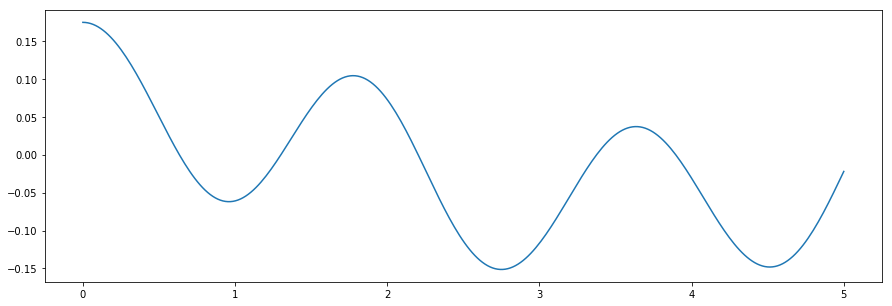

In [149]:
fig,ax = plt.subplots()
fig.set_size_inches(15,5)

ax.plot(t,y[:,1])

## Visualization

In [ ]:

def play(x):
    
    index = int((len(t)-1)*x/100)
    psi = y[index,0]
    
    pendulum_cylinder.axis = (pendulum_length*np.sin(psi),pendulum_length*np.cos(psi),0)
    

def play2(change):

    #x = interactive_plot.children[0].value
    x = slider.value

    play(x = x)

def plot(x):
    
    index = int((len(t)-1)*x/100)
    fig,ax = plt.subplots()
    ax.plot(t,y[:,0])
    ax.plot(t[index],y[index,0],'ro')
    display(fig)
    clear_output(wait=True)
    
    

In [ ]:

from ipywidgets import interactive


interactive_plot = interactive(plot, x=(0.0,100.0))
display(interactive_plot)


In [ ]:
scene2 = canvas(width = 1000,height = 500,up=vector(0,-1,0))
vscale = 3
varr = arrow(pos=vector(0,0,0), axis=vscale*vector(1,0,0), color=color.red,shaftwidth=vscale*0.1)
varr = arrow(pos=vector(0,0,0), axis=vscale*vector(0,1,0), color=color.green,shaftwidth=vscale*0.1)
varr = arrow(pos=vector(0,0,0), axis=vscale*vector(0,0,1), color=color.blue,shaftwidth=vscale*0.1)

pendulum_length = 10
pendulum_radius = 0.1
pendulum_cylinder = cylinder(pos = (0,0,0),axis = (0,1,0),length = pendulum_length,radius = pendulum_radius)

play_widget = widgets.Play(
    interval=0.5,
    value=0,
    min=0,
    max=100,
    description="Press play",
    disabled=False

)
slider = widgets.FloatSlider()
widgets.jslink((play_widget, 'value'), (slider, 'value'))
#widgets.jslink((play_widget, 'value'), (interactive_plot.children[0], 'value'))


play_widget.observe(play2, names='value')

scene2.visible = True
display(scene2)
#display(interactive_plot.children[1])

widgets.HBox([play_widget, slider])
#widgets.HBox([play_widget, interactive_plot.children[0]])
